In [3]:
import pandas as pd

# Загружаем датасет полностью
df = pd.read_parquet('transaction_fraud_data.parquet')

# Первые строки
display(df.head())

# Общая информация
df.info()

# Кол-во строк и уникальных сущностей
print("Количество строк:", len(df))
print("Уникальных клиентов:", df['customer_id'].nunique())
print("Уникальных карт:", df['card_number'].nunique())
print("Уникальных стран:", df['country'].nunique())
print("Уникальных городов:", df['city'].nunique())


,transaction_id,customer_id,card_number,timestamp,vendor_category,vendor_type,vendor,amount,currency,country,...,is_card_present,device,channel,device_fingerprint,ip_address,is_outside_home_country,is_high_risk_vendor,is_weekend,last_hour_activity,is_fraud
0,TX_a0ad2a2a,CUST_72886,6646734767813109,2024-09-30 00:00:01.034820,Restaurant,fast_food,Taco Bell,294.87,GBP,UK,...,False,iOS App,mobile,e8e6160445c935fd0001501e4cbac8bc,197.153.60.199,False,False,False,"{'num_transactions': 1197, 'total_amount': 334...",False
1,TX_3599c101,CUST_70474,376800864692727,2024-09-30 00:00:01.764464,Entertainment,gaming,Steam,3368.97,BRL,Brazil,...,False,Edge,web,a73043a57091e775af37f252b3a32af9,208.123.221.203,True,True,False,"{'num_transactions': 509, 'total_amount': 2011...",True
2,TX_a9461c6d,CUST_10715,5251909460951913,2024-09-30 00:00:02.273762,Grocery,physical,Whole Foods,102582.38,JPY,Japan,...,False,Firefox,web,218864e94ceaa41577d216b149722261,10.194.159.204,False,False,False,"{'num_transactions': 332, 'total_amount': 3916...",False
3,TX_7be21fc4,CUST_16193,376079286931183,2024-09-30 00:00:02.297466,Gas,major,Exxon,630.60,AUD,Australia,...,False,iOS App,mobile,70423fa3a1e74d01203cf93b51b9631d,17.230.177.225,False,False,False,"{'num_transactions': 764, 'total_amount': 2201...",False
4,TX_150f490b,CUST_87572,6172948052178810,2024-09-30 00:00:02.544063,Healthcare,medical,Medical Center,724949.27,NGN,Nigeria,...,False,Chrome,web,9880776c7b6038f2af86bd4e18a1b1a4,136.241.219.151,True,False,False,"{'num_transactions': 218, 'total_amount': 4827...",True


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7483766 entries, 0 to 7483765
Data columns (total 23 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   transaction_id           object        
 1   customer_id              object        
 2   card_number              int64         
 3   timestamp                datetime64[us]
 4   vendor_category          object        
 5   vendor_type              object        
 6   vendor                   object        
 7   amount                   float64       
 8   currency                 object        
 9   country                  object        
 10  city                     object        
 11  city_size                object        
 12  card_type                object        
 13  is_card_present          bool          
 14  device                   object        
 15  channel                  object        
 16  device_fingerprint       object        
 17  ip_address               ob

In [4]:
# 1. Пропуски по всем колонкам
print("Пропуски:")
display(df.isna().sum())

# 2. Считаем 'Unknown City', 'Unknown Country' и т.п.
print("\n'Unknown City' в city:", (df['city'] == 'Unknown City').sum())
print("'Unknown' в vendor:", (df['vendor'] == 'Unknown').sum())

# 3. Проверка аномалий в суммах
print("\nТранзакций с amount == 0:", (df['amount'] == 0).sum())
print("Транзакций с amount < 0:", (df['amount'] < 0).sum())
print("Минимальная сумма:", df['amount'].min())
print("Максимальная сумма:", df['amount'].max())

Пропуски:


,0
transaction_id,0
customer_id,0
card_number,0
timestamp,0
vendor_category,0
vendor_type,0
vendor,0
amount,0
currency,0
country,0



'Unknown City' в city: 6983706
'Unknown' в vendor: 0

Транзакций с amount == 0: 0
Транзакций с amount < 0: 0
Минимальная сумма: 0.01
Максимальная сумма: 6253152.62


Распаковка `last_hour_activity`

In [5]:
activity_df = pd.json_normalize(df['last_hour_activity'])
activity_df.columns = ['lha_num_tx', 'lha_total_amount', 'lha_unique_merchants', 'lha_unique_countries', 'lha_max_single_amount']
df = pd.concat([df, activity_df], axis=1)
df.groupby('is_fraud')['lha_num_tx'].describe()

,count,mean,std,min,25%,50%,75%,max
is_fraud,,,,,,,,
False,5989047.0,408.262533,390.672430,0.0,105.0,292.0,605.0,3962.0
True,1494719.0,412.670479,392.771128,0.0,108.0,296.0,611.0,3854.0


Работа с `timestamp`

In [6]:
# Убедимся, что это datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Извлекаем временные признаки
df['date'] = df['timestamp'].dt.floor('D')
df['hour'] = df['timestamp'].dt.hour
df['weekday'] = df['timestamp'].dt.weekday

# Фича: ночь (например, с 0 до 6 включительно)
df['is_night'] = df['hour'].apply(lambda h: 1 if 0 <= h <= 6 else 0)


Анализ суммы транзакций `amount`

In [7]:
print(df.columns)


Index(['transaction_id', 'customer_id', 'card_number', 'timestamp',
       'vendor_category', 'vendor_type', 'vendor', 'amount', 'currency',
       'country', 'city', 'city_size', 'card_type', 'is_card_present',
       'device', 'channel', 'device_fingerprint', 'ip_address',
       'is_outside_home_country', 'is_high_risk_vendor', 'is_weekend',
       'last_hour_activity', 'is_fraud', 'lha_num_tx', 'lha_total_amount',
       'lha_unique_merchants', 'lha_unique_countries', 'lha_max_single_amount',
       'date', 'hour', 'weekday', 'is_night'],
      dtype='object')


In [8]:
# Загружаем курсы валют
exchange = pd.read_parquet('/content/historical_currency_exchange.parquet')
exchange['date'] = pd.to_datetime(exchange['date'])  # Убедимся в типе datetime

# Преобразуем exchange из wide в long формат
exchange_long = exchange.melt(id_vars='date', var_name='currency', value_name='rate_to_usd')

# Убедимся, что всё в нужных типах
exchange_long['date'] = pd.to_datetime(exchange_long['date'])
df['date'] = df['timestamp'].dt.floor('D')

# Мержим
df = df.merge(exchange_long, how='left', on=['date', 'currency'])

# Пересчёт в доллары
df['usd_amount'] = df['amount'] / df['rate_to_usd']

# Быстрая проверка
print("Пропущенных значений usd_amount:", df['usd_amount'].isna().sum())


# --- Анализ ---
print("Общая статистика (usd_amount):")
display(df['usd_amount'].describe())

print("\nФрод (usd_amount):")
display(df[df['is_fraud'] == True]['usd_amount'].describe())

print("\nНе фрод (usd_amount):")
display(df[df['is_fraud'] == False]['usd_amount'].describe())

Пропущенных значений usd_amount: 0
Общая статистика (usd_amount):


,usd_amount
count,7.483766e+06
mean,5.426347e+02
std,7.284294e+02
min,2.406185e-03
25%,1.686272e+02
50%,3.592600e+02
75%,6.155200e+02
max,1.578154e+04



Фрод (usd_amount):


,usd_amount
count,1.494719e+06
mean,8.746068e+02
std,1.349883e+03
min,2.406185e-03
25%,3.533985e+00
50%,4.432179e+02
75%,1.292990e+03
max,1.578154e+04



Не фрод (usd_amount):


,usd_amount
count,5.989047e+06
mean,4.597826e+02
std,4.170077e+02
min,6.232713e+00
25%,1.923006e+02
50%,3.545359e+02
75%,5.287640e+02
max,3.170582e+03


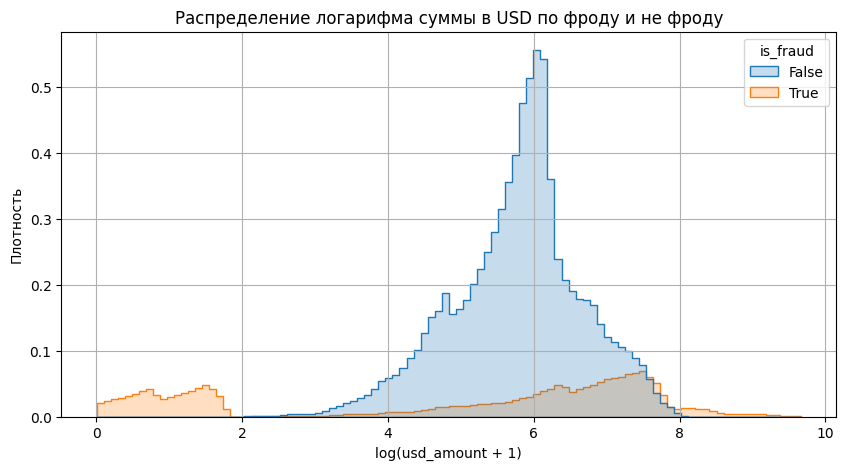

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Логарифм
df['log_usd_amount'] = df['usd_amount'].apply(lambda x: np.log1p(x))

plt.figure(figsize=(10, 5))
sns.histplot(data=df, x='log_usd_amount', hue='is_fraud', bins=100, element='step', stat='density')
plt.title('Распределение логарифма суммы в USD по фроду и не фроду')
plt.xlabel('log(usd_amount + 1)')
plt.ylabel('Плотность')
plt.grid(True)
plt.show()

Анализ времени

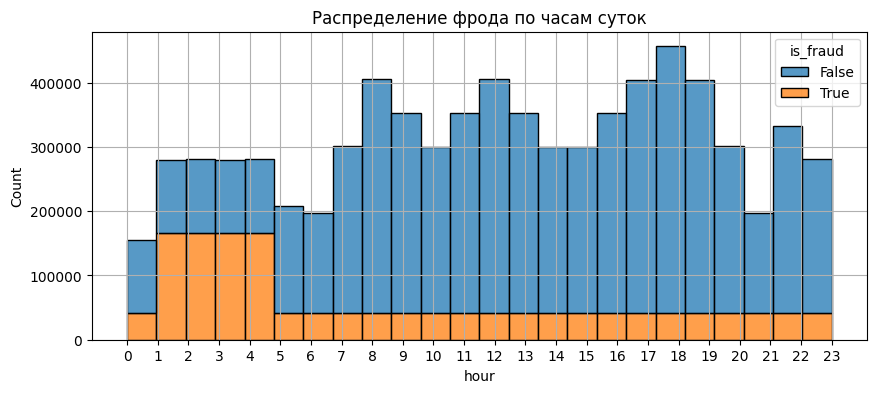

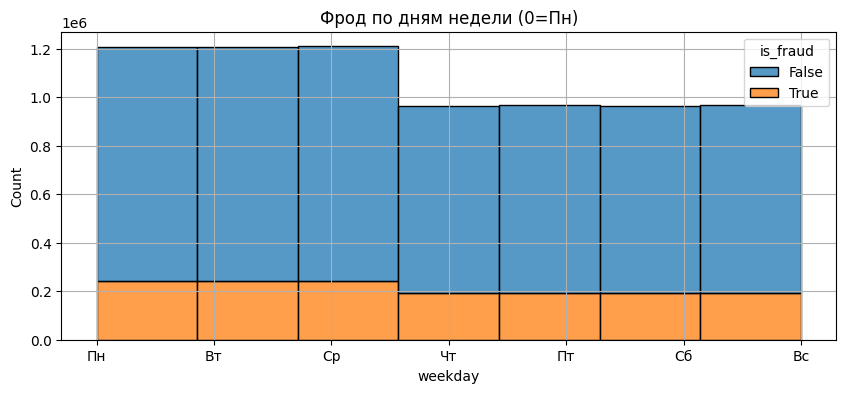

Доля фрода ночью: 0.469
Доля фрода днём: 0.122
Фрод в выходные: 0.2
Фрод в будни: 0.2


/tmp/ipython-input-13-2483509543.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Фрод в выходные:", round(weekend_fraud_rate[1], 3))
/tmp/ipython-input-13-2483509543.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Фрод в будни:", round(weekend_fraud_rate[0], 3))


In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Фрод по часам
plt.figure(figsize=(10, 4))
sns.histplot(data=df, x='hour', hue='is_fraud', multiple='stack', bins=24)
plt.title('Распределение фрода по часам суток')
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()

# 2. Фрод по дням недели
plt.figure(figsize=(10, 4))
sns.histplot(data=df, x='weekday', hue='is_fraud', multiple='stack', bins=7)
plt.title('Фрод по дням недели (0=Пн)')
plt.xticks(range(0, 7), ['Пн','Вт','Ср','Чт','Пт','Сб','Вс'])
plt.grid(True)
plt.show()

# 3. Фрод: ночь vs день
night_fraud_rate = df.groupby('is_night')['is_fraud'].mean()
print("Доля фрода ночью:", round(night_fraud_rate[1], 3))
print("Доля фрода днём:", round(night_fraud_rate[0], 3))

# 4. Фрод: будни vs выходные
weekend_fraud_rate = df.groupby('is_weekend')['is_fraud'].mean()
print("Фрод в выходные:", round(weekend_fraud_rate[1], 3))
print("Фрод в будни:", round(weekend_fraud_rate[0], 3))

Географиеский анализ

In [14]:
#топ стран по числу фродов
top_fraud_countries = (
    df[df['is_fraud'] == True]
    .groupby('country')
    .size()
    .sort_values(ascending=False)
    .head(10)
)

print("Топ-10 стран по количеству фродов:")
print(top_fraud_countries)

Топ-10 стран по количеству фродов:
country
Russia       299425
Mexico       298841
Brazil       298629
Nigeria      298600
Australia     37652
Japan         37592
France        37426
Singapore     37414
UK            37345
USA           37312
dtype: int64


In [15]:
fraud_rate_by_country = df.groupby('country')['is_fraud'].mean().sort_values(ascending=False)
print("Топ стран по доле фрода:")
print(fraud_rate_by_country.head(10))

Топ стран по доле фрода:
country
Mexico       0.380348
Russia       0.377238
Brazil       0.371060
Nigeria      0.351360
Australia    0.075805
USA          0.074615
Japan        0.071279
Germany      0.070939
Canada       0.069988
UK           0.069351
Name: is_fraud, dtype: float64


In [16]:
outside_rate = df.groupby('is_outside_home_country')['is_fraud'].mean()
print("Фрод ВНЕ страны клиента:", round(outside_rate[True], 3))
print("Фрод ВНУТРИ страны клиента:", round(outside_rate[False], 3))

Фрод ВНЕ страны клиента: 0.568
Фрод ВНУТРИ страны клиента: 0.025


Устройства и каналы

In [18]:
fraud_by_channel = df.groupby('channel')['is_fraud'].mean().sort_values(ascending=False)
print("Фрод по каналам:")
print(fraud_by_channel)


Фрод по каналам:
channel
pos       1.000000
mobile    0.123878
web       0.123275
Name: is_fraud, dtype: float64


In [3]:
top_devices = df['device'].value_counts().head(10).index
fraud_by_device = df[df['device'].isin(top_devices)].groupby('device')['is_fraud'].mean().sort_values(ascending=False)

print("Фрод по топ-устройствам:")
print(fraud_by_device)


Фрод по топ-устройствам:
device
Chip Reader        1.000000
NFC Payment        1.000000
Magnetic Stripe    1.000000
Firefox            0.126831
Safari             0.126204
Android App        0.125070
Chrome             0.123710
iOS App            0.122703
Edge               0.116753
Name: is_fraud, dtype: float64


Тип карты и наличие карты

In [4]:
fraud_by_card_type = df.groupby('card_type')['is_fraud'].mean().sort_values(ascending=False)
print("Фрод по типу карты:")
print(fraud_by_card_type)

Фрод по типу карты:
card_type
Basic Credit       0.199742
Platinum Credit    0.199731
Gold Credit        0.199729
Premium Debit      0.199721
Basic Debit        0.199720
Name: is_fraud, dtype: float64


In [5]:
fraud_by_presence = df.groupby('is_card_present')['is_fraud'].mean()
print("Фрод при наличии карты:", round(fraud_by_presence[True], 3))
print("Фрод без карты:", round(fraud_by_presence[False], 3))

Фрод при наличии карты: 1.0
Фрод без карты: 0.123


Поведенческий анализ активнотси за последний час

In [8]:
agg = df.groupby('is_fraud')[
    ['lha_num_tx', 'lha_total_amount', 'lha_unique_merchants', 'lha_unique_countries', 'lha_max_single_amount']
].mean()

print("Средние значения поведенческих признаков по фроду и не фроду:")
print(agg)


Средние значения поведенческих признаков по фроду и не фроду:
          lha_num_tx  lha_total_amount  lha_unique_merchants  \
is_fraud                                                       
False     408.262533      1.985784e+07             79.916723   
True      412.670479      2.015500e+07             80.445120   

          lha_unique_countries  lha_max_single_amount  
is_fraud                                               
False                10.650769           1.719987e+06  
True                 10.710001           1.752255e+06  


In [9]:
df[df['is_fraud'] == True][['lha_num_tx', 'lha_unique_merchants']].describe()


,lha_num_tx,lha_unique_merchants
count,1.494719e+06,1.494719e+06
mean,4.126705e+02,8.044512e+01
std,3.927711e+02,3.007012e+01
min,0.000000e+00,0.000000e+00
25%,1.080000e+02,6.400000e+01
50%,2.960000e+02,9.500000e+01
75%,6.110000e+02,1.040000e+02
max,3.854000e+03,1.050000e+02
